# Fake News Detection with Artificial Intelligence
## Final Year Project - By Kishan Godhania
---

### Packages:
This first section has all the packages that are used for the project, mostly scikit learn packages with some other packages for visual graphs.

In [22]:
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

---
### Database Statistics
The first graph below shows the breakdown of the dataset before any cleaning or preprocessing has been performed on it.

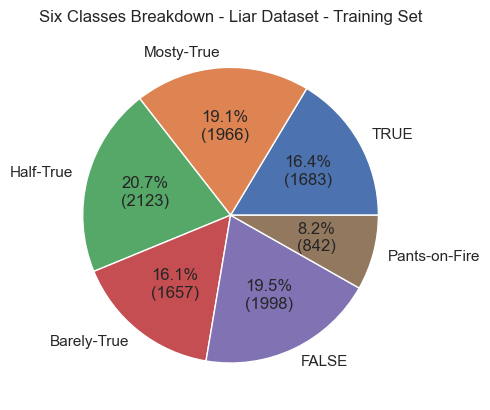

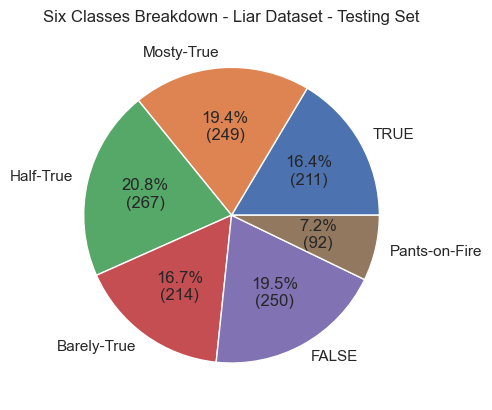

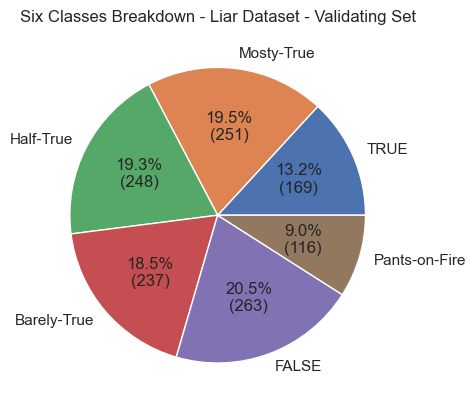

In [23]:
def databaseGraph(datasetSegment, setName):
    df = read_csv(datasetSegment, header = None)
    df.columns = ['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Occupation', 'Location','Party','Barely True Counts','False Counts','Half True Counts','Mostly True Counts','Pants on Fire Counts','Context']
    
    results = df['Label'].to_numpy()
    
    classTally = np.array([0, 0, 0, 0, 0, 0,])
    mylabels = ["TRUE", "Mosty-True","Half-True","Barely-True","FALSE","Pants-on-Fire"]

    for i in range(0,len(results)):
        if results[i] == "TRUE":
            classTally[0] += 1
        elif results[i] == "mostly-true":
            classTally[1] += 1
        elif results[i] == "half-true":
            classTally[2] += 1
        elif results[i] == "barely-true":
            classTally[3] += 1
        elif results[i] == "FALSE":
            classTally[4] += 1
        elif results[i] == "pants-fire":
            classTally[5] += 1
    
    plt.pie(classTally, labels = mylabels, autopct=lambda pct: func(pct, classTally))
    plt.title("Six Classes Breakdown - Liar Dataset - "+ setName)
    plt.show()
    
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"
    
databaseGraph("/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Train csv_version.csv", "Training Set")
databaseGraph("/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Test csv_version.csv", "Testing Set")
databaseGraph("/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Valid csv_version.csv", "Validating Set")

---
### Dataset Preprocessing - Cleaning
Then the cleaning process is performed on the dataset which includes the following:
- removing unnecessary columns
- removing missing records
- removing dupicate records
- concatinating the data together
- seperating the feature data and the class data
- dropping records that were assigned the "Half-True" class
- converting the remaining 5 classes into 2 classes

The graph shows the records for the new cleaned up dataset:

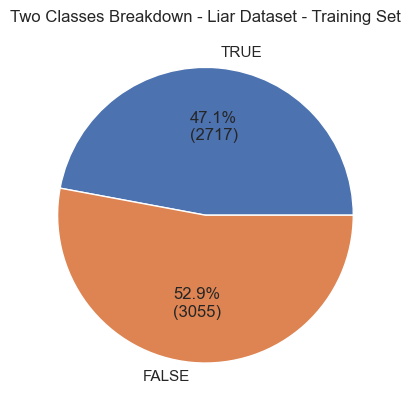

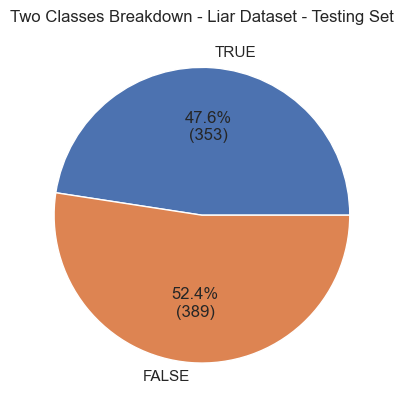

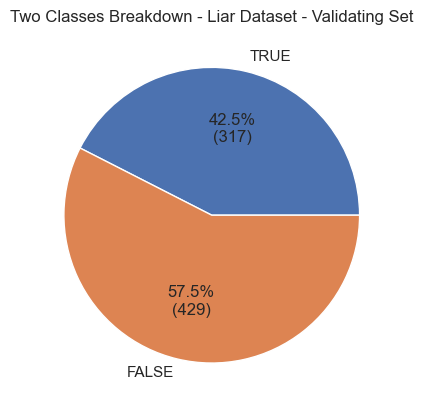

In [24]:
#Dataset Cleaning Method
def datasetPrep(dataset):
    #pulls data from csv
    df = read_csv(dataset, header=None)
    
    #add labels to all the columnns 
    df.columns = ['ID', 
                'Label',
                'Statement',
                'Subject',
                'Speaker',
                'Occupation',
                'Location',
                'Party',
                'Barely True Counts',
                'False Counts',
                'Half True Counts',
                'Mostly True Counts',
                'Pants on Fire Counts',
                'Context']
    
    #drops columns that are not helpful.
    df = df.drop(['Location',
                'Barely True Counts',
                'False Counts',
                'Half True Counts',
                'Mostly True Counts',
                'Pants on Fire Counts'], axis=1)
    
    #drops rows that have been labeled "half-true"
    df = df.drop(df[df['Label'] == 'half-true'].index)

    #drops rows with information missing in columns
    df = df.dropna()
    
    #drops rows with duplicates 
    df = df.drop_duplicates()  
    
    # combines all the different text information into one string.
    df['Combined Data'] = df['Statement'] + '\n' + df['Subject'] + '\n' + df['Speaker'] + '\n' + df['Party'] + '\n' + df['Occupation'] + '\n' + df['Context']
    
    X = df['Combined Data']
    
    Y = df['Label']
    
    #X = X.astype(str)
    Y = TwoClassConversion(Y)
    #print(X[0])

    return X, Y

# Class Conversion Method
def TwoClassConversion(outputs):
    outputs = outputs.replace(["barely-true","pants-fire"], "FALSE")
    outputs = outputs.replace(["mostly-true"], "TRUE")
    return outputs

# Graph Display Method
def cleanedDatasetGraph(Y, setName):
    results = Y.to_numpy()
    
    classTally = np.array([0, 0,])
    mylabels = ["TRUE", "FALSE"]

    for i in range(0,len(results)):
        if results[i] == "TRUE":
            classTally[0] += 1
        elif results[i] == "FALSE":
            classTally[1] += 1
    
    plt.pie(classTally, labels = mylabels, autopct=lambda pct: func(pct, classTally))
    plt.title("Two Classes Breakdown - Liar Dataset - "+ setName)
    plt.show()
    
X, Y = datasetPrep("/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Train csv_version.csv")
tX, tY = datasetPrep("/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Test csv_version.csv")
vX, vY = datasetPrep("/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Valid csv_version.csv")

cleanedDatasetGraph(Y, "Training Set")
cleanedDatasetGraph(tY, "Testing Set")
cleanedDatasetGraph(vY, "Validating Set")

### Dataset Preprocessing - Feature Extraction
The next coding sections extracts the features and transforms the data so that it can be used to train the machine learning models later.

In [25]:
def featureVectorizing(x,xTest,xValid):
   
    # setup count vectorizer and tfidf transformer
    count_vect = CountVectorizer()
    tfTransformer = TfidfTransformer()
    
    # feature extraction of training set
    xTrainCounts = count_vect.fit_transform(x)
    xTrainTF = tfTransformer.fit_transform(xTrainCounts)
    
    # feature extraction of testing set
    xTestCounts = count_vect.transform(xTest)
    xTestTF = tfTransformer.transform(xTestCounts)
    
    # feature extraction of validation set
    xValidCounts = count_vect.transform(xValid)
    xValidTF = tfTransformer.transform(xValidCounts)
    
    # converting feature extracted data strucutures into arrays
    xTrainTF = xTrainTF.toarray()
    xTestTF = xTestTF.toarray()
    xValidTF = xValidTF.toarray()
    
    return xTrainTF, xTestTF, xValidTF
    

In [26]:
def getData():
    # retrieve dataset from csv files
    trainDataset = "/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Train csv_version.csv"
    testDataset = "/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Test csv_version.csv"
    validDataset = "/Users/Kishan/Documents/Kishan/Repositories/fake-news-detection/Final Year Project Software/Data/Valid csv_version.csv"
    
    # apply data preprocessing to dataset
    x,y = datasetPrep(trainDataset)
    xT, yT = datasetPrep(testDataset)
    xV, yV = datasetPrep(validDataset)

    return x,y,xT,yT,xV,yV
    

### Testing Model - Performance
The method below test the model's performance using the test dataset.

It then returns the performance metrics of the model and creates a heatmap of the confusion matrix.

The second method also does K-fold Cross validation using the training set. It gets the average of all of the accuracies

In [27]:
def testModel(model, xT, yT, modelName):
    # tests predicition of model on test data
    predicted = model.predict(xT)
    
    # prints out performance metrics for a given model
    print(classification_report(yT, predicted))
   
    # creates heatmap confusion matrix 
    classes = ["False", "True"]
    confMatx = confusion_matrix(yT, predicted)
    confHeatMap = sns.heatmap(confMatx.T, square = True, annot = True, fmt = 'd', xticklabels = classes, yticklabels = classes)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.title(modelName)
    plt.show()

In [28]:
def kfold(modelName,model, x, y):
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(model, x, y, cv=kf, scoring='accuracy')
    # prints average accuracy from all 10 folds to 2 decimal places
    #print(modelName + ": %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print(modelName + ": %0.2f accuracy" % (scores.mean()))

In [29]:
def rocAUC(model, xT, yT, y, modelName):
    modProba = model.predict_proba(xT)
    modProba = modProba[:, 1]
    AucScore = roc_auc_score(yT, modProba)
    print(modelName + " AUC Score: %.3f" % (AucScore))

### Pipelines - Models
These are the different pipelines for the models.

Combining the Feature Extraction with the training of the models all into one method.

This then allows for hyperparameter tuning using GridSearchCV later on.

In [30]:
def nbPipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
])
    return pipeline

In [31]:
def svmPipeline():
        pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(probability=True,random_state=42))
])
        return pipeline

In [32]:
def decisionTreePipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier(random_state=42))
    ])
    return pipeline


In [33]:
def randomForestPipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    return pipeline

In [34]:
def xgBoostPipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42))
    ])
    return pipeline
    

### Hyperparameter Tuning - Optimisation
This method does hyperparamter tuning based on the parameter grid that is provided.

In [35]:
def parameterTuning(model, x, y, parameters): 
    gsModel = GridSearchCV(model, parameters, cv=10, n_jobs=-1)
    gsModel.fit(x, y)
    return gsModel

### SMOTE Pipelines
New Pipelines had to be implemented to accomodate SMOTE

These pipelines are identical in every other way to the other ones above besides that fact that they have SMOTE in the structure. 

This allows for these models to also have hyperparameter tuning like the other ones above.

In [36]:
def nbSmote():
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('SMOTE', SMOTE(random_state=42)),
        ('clf', MultinomialNB())
])
    return pipeline

In [37]:
def svmSmote():
        pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', SVC(probability=True, random_state=42))
])
        return pipeline

In [38]:
def decisionTreeSmote():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', DecisionTreeClassifier(random_state=42))
    ])
    return pipeline


In [39]:
def randomForestSmote():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    return pipeline

In [40]:
def xgBoostSmote():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42))
    ])
    return pipeline
    

### Running all the models
The following functions runs all of the models and provides the performance metrics and the heatmap from the method above. 

In [41]:
def runPipeline(modelName, modelPipeline, hypParam, smotePipeline):
    print(modelName)
    x,y,xT,yT,xV,yV = getData()
    model = modelPipeline()
    model.fit(x,y)
    testModel(model, xT, yT, modelName)
    rocAUC(model, xT, yT, y, modelName)
    
    print("")
    modelKfold = modelPipeline()
    kfold(modelName, modelKfold, x, y)
    
    print("")
    print(modelName + " with Hyperparameter Tuning")
    modelTuned = parameterTuning(model, xV, yV, hypParam)
    testModel(modelTuned, xT, yT, modelName + " HP Tuned")
    rocAUC(modelTuned, xT, yT, y, modelName + " HP Tuned")
    
    print("")
    print(modelName + " with Hyperparameter Tuning and SMOTE")
    modelSmote = smotePipeline()
    modelSmote = modelSmote.fit(x,y)
    smoteTuned = parameterTuning(modelSmote, xV, yV, hypParam)
    testModel(smoteTuned, xT, yT, modelName + " HP Tuned + SMOTE")
    rocAUC(smoteTuned, xT, yT, y, modelName + " HP Tuned + SMOTE")
    


Multinomial Naive Bayes
              precision    recall  f1-score   support

       FALSE       0.62      0.74      0.68       389
        TRUE       0.64      0.50      0.56       353

    accuracy                           0.63       742
   macro avg       0.63      0.62      0.62       742
weighted avg       0.63      0.63      0.62       742



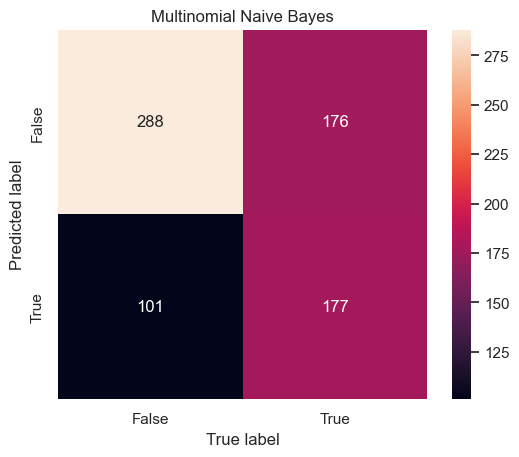

Multinomial Naive Bayes AUC Score: 0.673

Multinomial Naive Bayes: 0.63 accuracy

Multinomial Naive Bayes with Hyperparameter Tuning
              precision    recall  f1-score   support

       FALSE       0.59      0.65      0.62       389
        TRUE       0.57      0.51      0.54       353

    accuracy                           0.58       742
   macro avg       0.58      0.58      0.58       742
weighted avg       0.58      0.58      0.58       742



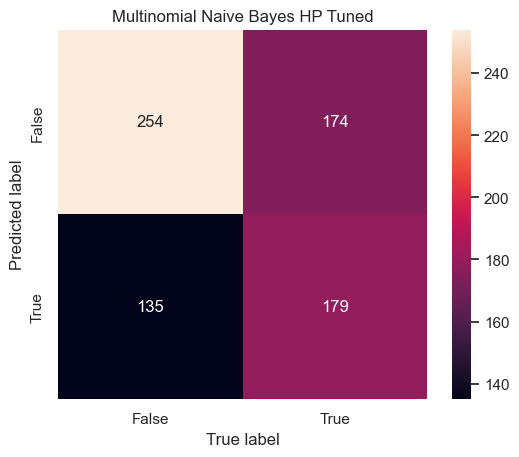

Multinomial Naive Bayes HP Tuned AUC Score: 0.614

Multinomial Naive Bayes with Hyperparameter Tuning and SMOTE
              precision    recall  f1-score   support

       FALSE       0.59      0.61      0.60       389
        TRUE       0.55      0.52      0.54       353

    accuracy                           0.57       742
   macro avg       0.57      0.57      0.57       742
weighted avg       0.57      0.57      0.57       742



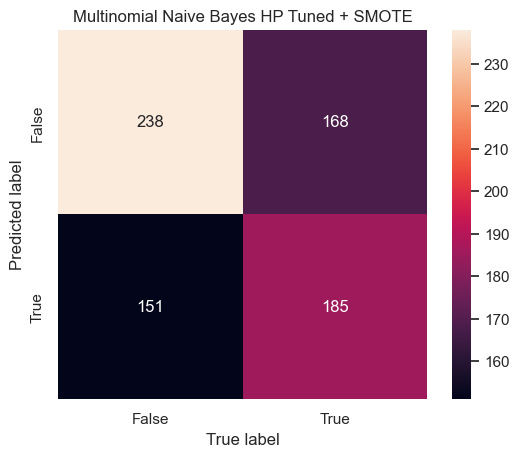

Multinomial Naive Bayes HP Tuned + SMOTE AUC Score: 0.599
Support Vector Machine
              precision    recall  f1-score   support

       FALSE       0.65      0.68      0.67       389
        TRUE       0.63      0.60      0.62       353

    accuracy                           0.64       742
   macro avg       0.64      0.64      0.64       742
weighted avg       0.64      0.64      0.64       742



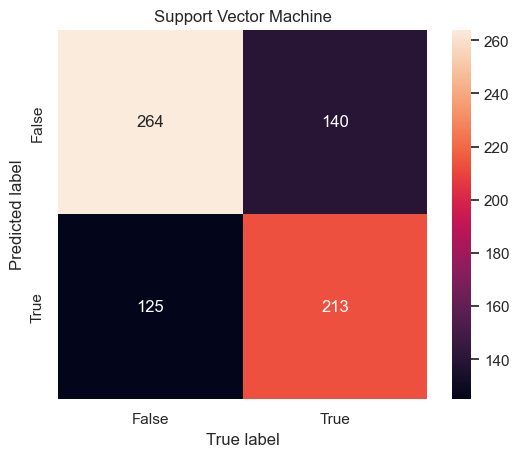

Support Vector Machine AUC Score: 0.694

Support Vector Machine: 0.64 accuracy

Support Vector Machine with Hyperparameter Tuning
              precision    recall  f1-score   support

       FALSE       0.60      0.68      0.63       389
        TRUE       0.58      0.50      0.54       353

    accuracy                           0.59       742
   macro avg       0.59      0.59      0.59       742
weighted avg       0.59      0.59      0.59       742



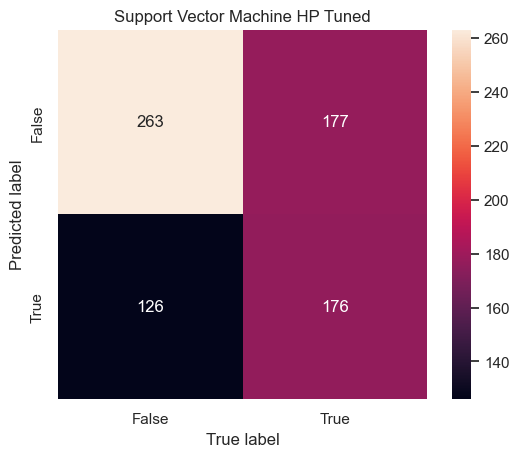

Support Vector Machine HP Tuned AUC Score: 0.649

Support Vector Machine with Hyperparameter Tuning and SMOTE
              precision    recall  f1-score   support

       FALSE       0.59      0.66      0.62       389
        TRUE       0.57      0.50      0.53       353

    accuracy                           0.58       742
   macro avg       0.58      0.58      0.57       742
weighted avg       0.58      0.58      0.58       742



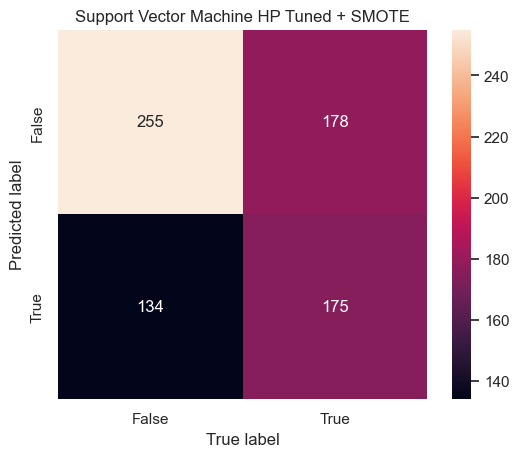

Support Vector Machine HP Tuned + SMOTE AUC Score: 0.649
Decision Tree
              precision    recall  f1-score   support

       FALSE       0.60      0.59      0.59       389
        TRUE       0.55      0.56      0.56       353

    accuracy                           0.58       742
   macro avg       0.58      0.58      0.58       742
weighted avg       0.58      0.58      0.58       742



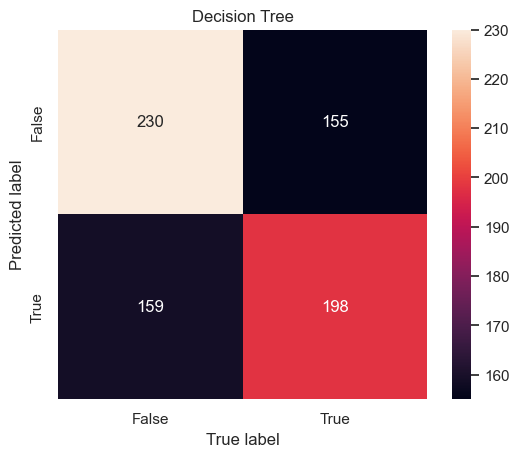

Decision Tree AUC Score: 0.576

Decision Tree: 0.57 accuracy

Decision Tree with Hyperparameter Tuning
              precision    recall  f1-score   support

       FALSE       0.53      0.94      0.68       389
        TRUE       0.57      0.09      0.16       353

    accuracy                           0.54       742
   macro avg       0.55      0.51      0.42       742
weighted avg       0.55      0.54      0.43       742



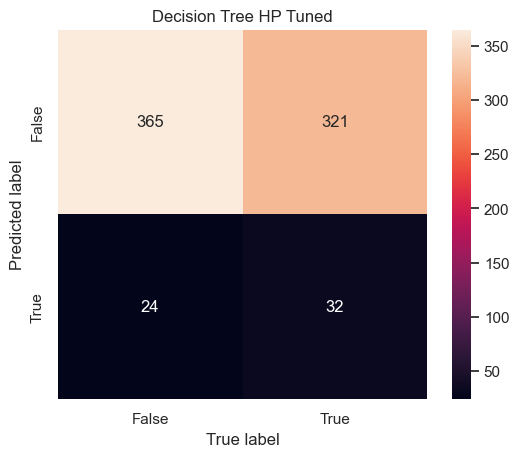

Decision Tree HP Tuned AUC Score: 0.578

Decision Tree with Hyperparameter Tuning and SMOTE
              precision    recall  f1-score   support

       FALSE       0.59      0.68      0.63       389
        TRUE       0.58      0.48      0.53       353

    accuracy                           0.59       742
   macro avg       0.59      0.58      0.58       742
weighted avg       0.59      0.59      0.58       742



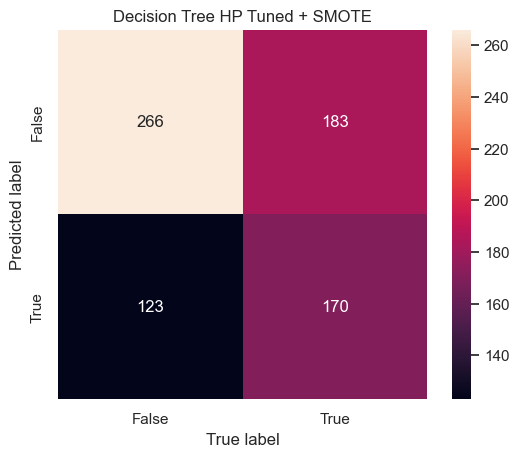

Decision Tree HP Tuned + SMOTE AUC Score: 0.594
Random Forest
              precision    recall  f1-score   support

       FALSE       0.64      0.73      0.68       389
        TRUE       0.65      0.55      0.59       353

    accuracy                           0.64       742
   macro avg       0.65      0.64      0.64       742
weighted avg       0.64      0.64      0.64       742



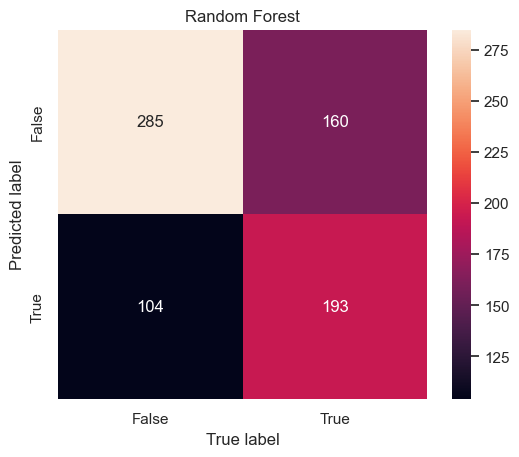

Random Forest AUC Score: 0.693

Random Forest: 0.64 accuracy

Random Forest with Hyperparameter Tuning
              precision    recall  f1-score   support

       FALSE       0.55      0.90      0.68       389
        TRUE       0.62      0.18      0.27       353

    accuracy                           0.56       742
   macro avg       0.58      0.54      0.48       742
weighted avg       0.58      0.56      0.49       742



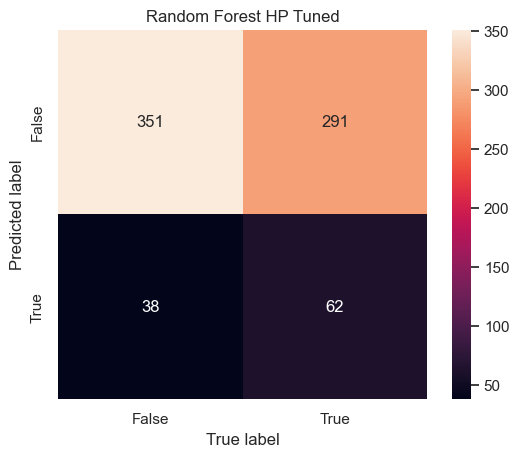

Random Forest HP Tuned AUC Score: 0.637

Random Forest with Hyperparameter Tuning and SMOTE
              precision    recall  f1-score   support

       FALSE       0.57      0.80      0.67       389
        TRUE       0.61      0.34      0.44       353

    accuracy                           0.58       742
   macro avg       0.59      0.57      0.55       742
weighted avg       0.59      0.58      0.56       742



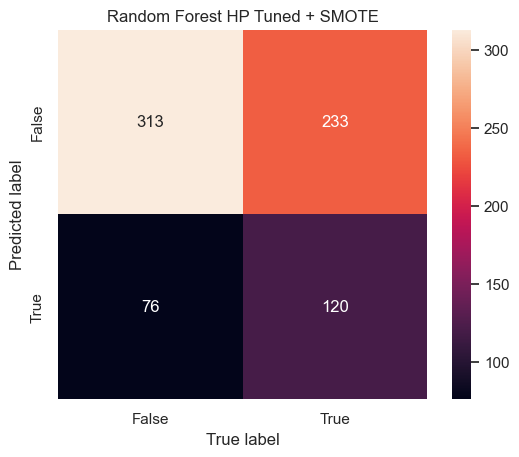

Random Forest HP Tuned + SMOTE AUC Score: 0.633

XGBoost
              precision    recall  f1-score   support

       FALSE       0.63      0.66      0.65       389
        TRUE       0.61      0.58      0.59       353

    accuracy                           0.62       742
   macro avg       0.62      0.62      0.62       742
weighted avg       0.62      0.62      0.62       742



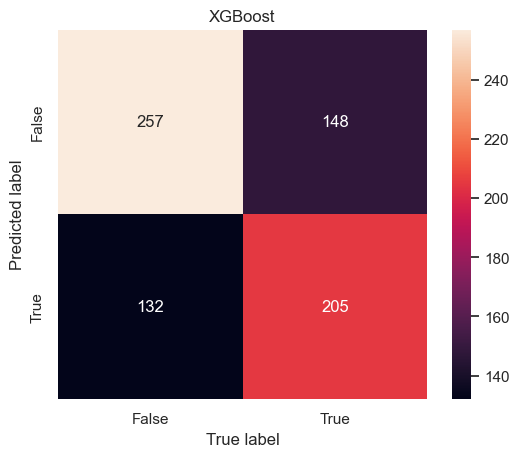

XGBoost AUC Score: 0.643
XGBoost: 0.61 accuracy


In [42]:
def runAll():
    mnbParameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        "tfidf__norm": ("l1", "l2"), # maybe remove this
        'clf__alpha': (1e-2, 1e-3)
    }
        
    SvmSvcParameters = {        
        "vect__ngram_range": ((1, 1), (1, 2)),
        "tfidf__use_idf": (True, False),
        "tfidf__norm": ("l1", "l2"),
        'clf__C': (0.1, 1, 10, 100),
        'clf__gamma': (0.01, 0.1, 1, 10),
        'clf__kernel': ('rbf', 'linear', 'poly')}
    
    decTreeParam = {
        "vect__ngram_range": ((1, 1), (1, 2)),
        "tfidf__use_idf": (True, False),
        "tfidf__norm": ("l1", "l2"),
        "clf__max_depth": (np.arange(2, 10, 1))
    }
    
    randForestParam = {
        "vect__ngram_range": ((1, 1), (1, 2)),
        "tfidf__use_idf": (True, False),
        "tfidf__norm": ("l1", "l2"),
        "clf__max_features": (1, 5),
        "clf__n_estimators": (10, 100, 1000)
    }
    
    runPipeline("Multinomial Naive Bayes", nbPipeline, mnbParameters, nbSmote)
    runPipeline("Support Vector Machine", svmPipeline, SvmSvcParameters, svmSmote)
    runPipeline("Decision Tree", decisionTreePipeline, decTreeParam, decisionTreeSmote)
    runPipeline("Random Forest", randomForestPipeline, randForestParam, randomForestSmote)
    
    x,y,xT,yT,xV,yV = getData()    
    print()
    print("XGBoost")
    xgBoostModel = xgBoostPipeline()
    xgBoostModel = xgBoostModel.fit(x,y)
    testModel(xgBoostModel, xT, yT, "XGBoost")
    rocAUC(xgBoostModel, xT, yT, y, "XGBoost")
    
    xgBoostKfold = xgBoostPipeline()
    kfold("XGBoost", xgBoostKfold, x,y)

runAll()